# 01. EDA, CDR Anonymization & Data Quality Notebook 


## Setup - Imports and SparkSession

In [4]:
import sys
sys.path.append('/home/jovyan/work/work/scripts')
from spark_init import init_spark
import hashlib
from pyspark.sql import functions as F, types as T
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Initialize Spark with proper configuration
spark = init_spark("CDR Anonymization - Complete Pipeline")
print("✅ SparkSession initialized")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/29 20:14:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ SparkSession initialized (App: CDR Anonymization - Complete Pipeline, Spark: 3.5.1)
✅ Hive Warehouse: hdfs://namenode:9000/user/hive/warehouse
✅ Hive Metastore URI: thrift://hive-metastore:9083
✅ SparkSession initialized


### 1. Load Raw CDR Data and Inspect

In [7]:
RAW_PATH = "/user/hive/warehouse/raw/*.csv"
ANONYMIZED_PATH = "/user/hive/warehouse/cdr_anonymized/"

# Load raw data
df_raw = spark.read.option("header", True).csv(RAW_PATH)
total_rows = df_raw.count()
print(f"\n📊 RAW DATA STATISTICS:")
print(f"   Total rows loaded: {total_rows:,}")
print(f"   Total columns: {len(df_raw.columns)}")
print(f"\n   Available columns:")
for i, col in enumerate(df_raw.columns, 1):
    print(f"   {i:3d}. {col}")


📊 RAW DATA STATISTICS:
   Total rows loaded: 89,911
   Total columns: 429

   Available columns:
     1. CDR_ID
     2. CDR_SUB_ID
     3. CDR_TYPE
     4. SPLIT_CDR_REASON
     5. CDR_BATCH_ID
     6. SRC_REC_LINE_NO
     7. SRC_CDR_ID
     8. SRC_CDR_NO
     9. STATUS
    10. RE_RATING_TIMES
    11. CREATE_DATE
    12. START_DATE
    13. END_DATE
    14. CUST_LOCAL_START_DATE
    15. CUST_LOCAL_END_DATE
    16. STD_EVT_TYPE_ID
    17. EVT_SOURCE_CATEGORY
    18. OBJ_TYPE
    19. OBJ_ID
    20. OWNER_CUST_ID
    21. DEFAULT_ACCT_ID
    22. PRI_IDENTITY
    23. BILL_CYCLE_ID
    24. SERVICE_CATEGORY
    25. USAGE_SERVICE_TYPE
    26. SESSION_ID
    27. RESULT_CODE
    28. RESULT_REASON
    29. BE_ID
    30. HOT_SEQ
    31. CP_ID
    32. RECIPIENT_NUMBER
    33. USAGE_MEASURE_ID
    34. ACTUAL_USAGE
    35. RATE_USAGE
    36. SERVICE_UNIT_TYPE
    37. USAGE_MEASURE_ID2
    38. ACTUAL_USAGE2
    39. RATE_USAGE2
    40. SERVICE_UNIT_TYPE2
    41. DEBIT_AMOUNT
    42. UN_DEBIT_AMOUNT
    

Avant d’entrer dans l’anonymisation et la transformation des données CDR, il est essentiel de bien comprendre la structure, la qualité et la distribution de la donnée brute. Cette étape permet de garantir que le pipeline respecte les meilleures pratiques d’ingénierie de la donnée, tout en assurant la transparence et la reproductibilité des analyses pour les équipes techniques et métier.

J'ai donc réalisé une analyse exploratoire détaillée (EDA) sur le jeu de données CDR, en mettant l’accent sur la couverture temporelle, les valeurs aberrantes, la complétude et la diversité des usages, afin d’optimiser la suite du pipeline.

### Analyse exploratoire des données (EDA)

#### Objectifs

Cette étape vise à :

- Comprendre la structure globale et les principales statistiques du dataset brut

- Repérer les valeurs manquantes, les incohérences et les anomalies potentielles

- Explorer la répartition temporelle et les usages pour la période couverte

- Valider la qualité du dataset avant anonymisation et transformation

### 2.1. Vue d’ensemble du jeu de données

Nous commençons par charger les données brutes et afficher les premières informations :

In [8]:
print(f"Lignes : {df_raw.count():,}")
print(f"Colonnes : {len(df_raw.columns)}")
df_raw.printSchema()
df_raw.show(5, truncate=False)


Lignes : 89,911
Colonnes : 429
root
 |-- CDR_ID: string (nullable = true)
 |-- CDR_SUB_ID: string (nullable = true)
 |-- CDR_TYPE: string (nullable = true)
 |-- SPLIT_CDR_REASON: string (nullable = true)
 |-- CDR_BATCH_ID: string (nullable = true)
 |-- SRC_REC_LINE_NO: string (nullable = true)
 |-- SRC_CDR_ID: string (nullable = true)
 |-- SRC_CDR_NO: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- RE_RATING_TIMES: string (nullable = true)
 |-- CREATE_DATE: string (nullable = true)
 |-- START_DATE: string (nullable = true)
 |-- END_DATE: string (nullable = true)
 |-- CUST_LOCAL_START_DATE: string (nullable = true)
 |-- CUST_LOCAL_END_DATE: string (nullable = true)
 |-- STD_EVT_TYPE_ID: string (nullable = true)
 |-- EVT_SOURCE_CATEGORY: string (nullable = true)
 |-- OBJ_TYPE: string (nullable = true)
 |-- OBJ_ID: string (nullable = true)
 |-- OWNER_CUST_ID: string (nullable = true)
 |-- DEFAULT_ACCT_ID: string (nullable = true)
 |-- PRI_IDENTITY: string (nullable = t

25/06/29 20:18:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+----------+--------+----------------+------------------+---------------+----------+------------------+------+---------------+--------------+--------------+--------------+---------------------+-------------------+---------------+-------------------+--------+------------------+------------------+------------------+------------+-------------+----------------+------------------+--------------------------------------------------------------+-----------+-------------+-----+-------+-----+----------------+----------------+------------+----------+-----------------+-----------------+-------------+-----------+------------------+------------+---------------+------------------+--------------------------+-------------------+---------------------------+--------------------------+---------+-------------------------+----------------------------+------------------------+---------------------+---------------------+------------+------------+-----------+-----------+---------+---------+-

### 2.2. Statistiques descriptives
Calcul des statistiques descriptives sur les principales colonnes numériques (utilisation, revenu, etc.) :

In [9]:
colonnes_numeriques = [
    "ACTUAL_USAGE", "RATE_USAGE", "DEBIT_AMOUNT", 
    "UN_DEBIT_AMOUNT", "TOTAL_TAX", "ChargingTime"
]
df_raw.select([F.col(c).cast("double") for c in colonnes_numeriques]).describe().show()


+-------+------------------+------------------+-----------------+---------------+---------+--------------------+
|summary|      ACTUAL_USAGE|        RATE_USAGE|     DEBIT_AMOUNT|UN_DEBIT_AMOUNT|TOTAL_TAX|        ChargingTime|
+-------+------------------+------------------+-----------------+---------------+---------+--------------------+
|  count|             89911|             89911|            89911|          89911|    89911|               89911|
|   mean|161.13353204835894|182.34904516688727|512.7482176819299|            0.0|      0.0|2.024939267698386...|
| stddev| 349.9082680814868| 352.1888714094337|1845.069540734217|            0.0|      0.0| 2.404531702226336E9|
|    min|               0.0|               0.0|              0.0|            0.0|      0.0|  2.0241231211909E13|
|    max|            3604.0|            3660.0|          95899.0|            0.0|      0.0|  2.0250101133522E13|
+-------+------------------+------------------+-----------------+---------------+---------+-----

### On remplace les points par des underscores dans tous les noms de colonnes

In [12]:
df_raw = df_raw.toDF(*[c.replace('.', '_') for c in df_raw.columns])

### 2.3. Analyse des valeurs manquantes

Certains noms de colonnes contiennent des points (`.`), ce qui peut générer des erreurs lors de l’utilisation de PySpark (car Spark interprète alors ces colonnes comme des structures ou des champs imbriqués).  
Pour éviter tout problème, on remplace les points par des underscores sur toutes les colonnes du DataFrame :


In [13]:
from pyspark.sql.functions import col, sum as Fsum

missing_counts = df_raw.select([
    Fsum(col(c).isNull().cast("int")).alias(c) for c in df_raw.columns
]).toPandas().T
missing_counts.columns = ["Manquantes"]
missing_counts["%"] = missing_counts["Manquantes"] / df_raw.count() * 100
missing_counts = missing_counts[missing_counts["Manquantes"] > 0].sort_values("Manquantes", ascending=False)
missing_counts


,Manquantes,%
ACCT_BALANCE_ID_12,89911,100.000000
OPER_TYPE_27,89911,100.000000
OPER_TYPE_28,89911,100.000000
CURRENCY_ID_18,89911,100.000000
CURRENT_BALANCE_8,89911,100.000000
...,...,...
CHG_BALANCE,54749,60.892438
CUR_BALANCE,54749,60.892438
BALANCE_TYPE,54749,60.892438
TFTFlag,760,0.845280


(Afficher éventuellement les 10 colonnes les plus concernées)

### 2.4. Valeurs uniques et répartition catégorielle

In [14]:
colonnes_categ = [
    "SERVICE_CATEGORY", "USAGE_SERVICE_TYPE", "CallType", "RoamState", "BrandID"
]
for c in colonnes_categ:
    print(f"\nColonne : {c}")
    df_raw.groupBy(c).count().orderBy('count', ascending=False).show(10)



Colonne : SERVICE_CATEGORY


+----------------+-----+
|SERVICE_CATEGORY|count|
+----------------+-----+
|               1|89911|
+----------------+-----+


Colonne : USAGE_SERVICE_TYPE
+------------------+-----+
|USAGE_SERVICE_TYPE|count|
+------------------+-----+
|                11|54832|
|                10|32941|
|                13| 2138|
+------------------+-----+


Colonne : CallType
+--------+-----+
|CallType|count|
+--------+-----+
|       1|47743|
|       0|40030|
|       3| 2138|
+--------+-----+


Colonne : RoamState
+---------+-----+
|RoamState|count|
+---------+-----+
|        0|89911|
+---------+-----+


Colonne : BrandID
+-------+-----+
|BrandID|count|
+-------+-----+
|      2|70710|
|      8|18379|
|      3|  822|
+-------+-----+



### 2.5. Couverture temporelle
Distribution des enregistrements dans le temps pour vérifier la couverture attendue :

In [15]:
if "START_DATE" in df_raw.columns:
    df_raw.withColumn(
        "parsed_date", F.to_date(F.col("START_DATE").substr(1, 8), "yyyyMMdd")
    ).groupBy("parsed_date").count().orderBy("parsed_date").show(30, False)


+-----------+-----+
|parsed_date|count|
+-----------+-----+
|2024-12-31 |7181 |
|2025-01-01 |82730|
+-----------+-----+



(On peut également visualiser la distribution horaire si besoin)

### 2.6. Détection des valeurs extrêmes
Analyse des distributions pour repérer les outliers :
Exemple : ACTUAL_USAGE (durée des appels en secondes)

In [17]:
# cast AVANT d’utiliser histogram
df_raw = df_raw.withColumn("ACTUAL_USAGE", F.col("ACTUAL_USAGE").cast("double"))

usage_hist = df_raw.select("ACTUAL_USAGE").rdd.flatMap(lambda x: x).histogram([0, 30, 60, 120, 300, 600, 1800, 3600])
print("Tranches ACTUAL_USAGE :", usage_hist[0])
print("Effectifs :", usage_hist[1])


Tranches ACTUAL_USAGE : [0, 30, 60, 120, 300, 600, 1800, 3600]
Effectifs : [27748, 21994, 18478, 10348, 5394, 5031, 876]


In [19]:
df_raw.printSchema()


root
 |-- CDR_ID: string (nullable = true)
 |-- CDR_SUB_ID: string (nullable = true)
 |-- CDR_TYPE: string (nullable = true)
 |-- SPLIT_CDR_REASON: string (nullable = true)
 |-- CDR_BATCH_ID: string (nullable = true)
 |-- SRC_REC_LINE_NO: string (nullable = true)
 |-- SRC_CDR_ID: string (nullable = true)
 |-- SRC_CDR_NO: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- RE_RATING_TIMES: string (nullable = true)
 |-- CREATE_DATE: string (nullable = true)
 |-- START_DATE: string (nullable = true)
 |-- END_DATE: string (nullable = true)
 |-- CUST_LOCAL_START_DATE: string (nullable = true)
 |-- CUST_LOCAL_END_DATE: string (nullable = true)
 |-- STD_EVT_TYPE_ID: string (nullable = true)
 |-- EVT_SOURCE_CATEGORY: string (nullable = true)
 |-- OBJ_TYPE: string (nullable = true)
 |-- OBJ_ID: string (nullable = true)
 |-- OWNER_CUST_ID: string (nullable = true)
 |-- DEFAULT_ACCT_ID: string (nullable = true)
 |-- PRI_IDENTITY: string (nullable = true)
 |-- BILL_CYCLE_ID: string

### 2.7. Vérification des doublons
Recherche de doublons sur les identifiants de CDR et sur l’ensemble de la ligne :

In [20]:
doublons_id = df_raw.count() - df_raw.dropDuplicates(["CDR_ID"]).count()
print(f"Doublons sur CDR_ID : {doublons_id}")

doublons_lignes = df_raw.count() - df_raw.dropDuplicates().count()
print(f"Doublons complets : {doublons_lignes}")


Doublons sur CDR_ID : 86371


Doublons complets : 0


### 2.8. Corrélations entre variables (optionnel/avancé)
Calcul des corrélations entre variables numériques (sur un échantillon, pour performance) :

In [21]:
echantillon = df_raw.select(colonnes_numeriques).sample(fraction=0.05).toPandas()
print(echantillon.corr())


                 ACTUAL_USAGE  RATE_USAGE  DEBIT_AMOUNT  UN_DEBIT_AMOUNT  \
ACTUAL_USAGE         1.000000    0.998297      0.149358              NaN   
RATE_USAGE           0.998297    1.000000      0.155050              NaN   
DEBIT_AMOUNT         0.149358    0.155050      1.000000              NaN   
UN_DEBIT_AMOUNT           NaN         NaN           NaN              NaN   
TOTAL_TAX                 NaN         NaN           NaN              NaN   
ChargingTime         0.064312    0.069741     -0.001013              NaN   

                 TOTAL_TAX  ChargingTime  
ACTUAL_USAGE           NaN      0.064312  
RATE_USAGE             NaN      0.069741  
DEBIT_AMOUNT           NaN     -0.001013  
UN_DEBIT_AMOUNT        NaN           NaN  
TOTAL_TAX              NaN           NaN  
ChargingTime           NaN      1.000000  


### 2.9 Visualisations avancées des données CDR

Dans cette partie, nous présentons plusieurs visualisations permettant de mieux appréhender la structure et les caractéristiques du jeu de données CDR. Ces graphiques aident à détecter les tendances générales, à repérer d’éventuelles valeurs extrêmes ou anomalies, et à mieux comprendre la diversité des usages.


#### 2.9.1. Histogramme de la durée des usages

L’histogramme ci-dessous montre la distribution de la variable `ACTUAL_USAGE` sur un échantillon de 5% du dataset.  
On constate que la majorité des événements sont de courte durée, avec quelques cas extrêmes (valeurs aberrantes possibles).

*Figure : Distribution de la durée des usages (ACTUAL_USAGE) — Histogramme sur 5% des données*

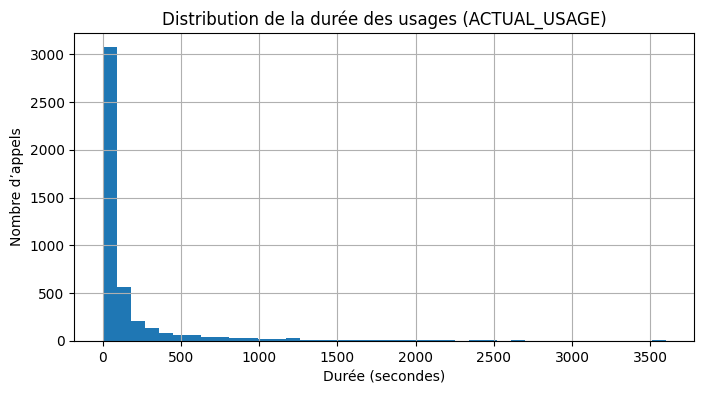

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
echantillon["ACTUAL_USAGE"].hist(bins=40)
plt.title("Distribution de la durée des usages (ACTUAL_USAGE)")
plt.xlabel("Durée (secondes)")
plt.ylabel("Nombre d’appels")
plt.show()


### 2.9.2. Boxplot des montants débités

Le boxplot suivant représente la distribution des montants débités (`DEBIT_AMOUNT`) pour chaque événement CDR.  
Cette visualisation est utile pour repérer rapidement la présence de valeurs extrêmes, la dispersion des valeurs et le niveau médian des transactions.


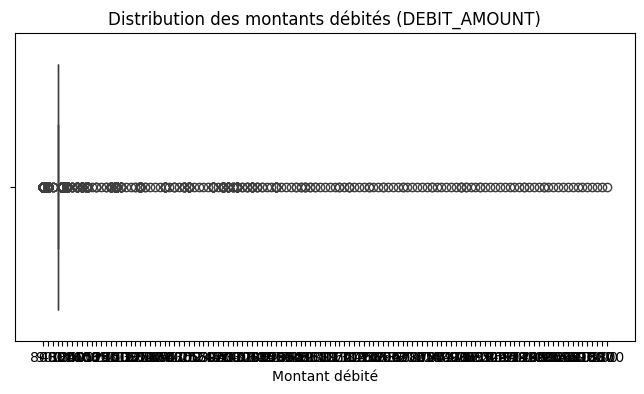

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.boxplot(x=echantillon["DEBIT_AMOUNT"])
plt.title("Distribution des montants débités (DEBIT_AMOUNT)")
plt.xlabel("Montant débité")
plt.show()


### 2.9.3. Heatmap du volume horaire d’appels par jour

La heatmap ci-dessous synthétise le volume total d’appels (ou de sessions) pour chaque heure de chaque journée couverte par le jeu de données.  
Cette représentation visuelle permet de :

- Détecter les périodes de pic d’activité (ex. : événements, pannes, ou surcharge du réseau)
- Repérer les creux (ex. : nuit, heures creuses)
- Visualiser d’éventuels schémas saisonniers ou ponctuels

In [37]:
# We add: START_DATE to List 
colonnes_viz = colonnes_numeriques + ["START_DATE"]
echantillon = df_raw.select(colonnes_viz).sample(fraction=0.05).toPandas()


In [38]:
echantillon = echantillon[echantillon["START_DATE"].notnull()]
echantillon["CDR_DAY"] = echantillon["START_DATE"].str[:8]
echantillon["HOUR"] = echantillon["START_DATE"].str[8:10].astype(int)


In [39]:
agg = echantillon.groupby(["CDR_DAY", "HOUR"]).size().reset_index(name="total_calls")


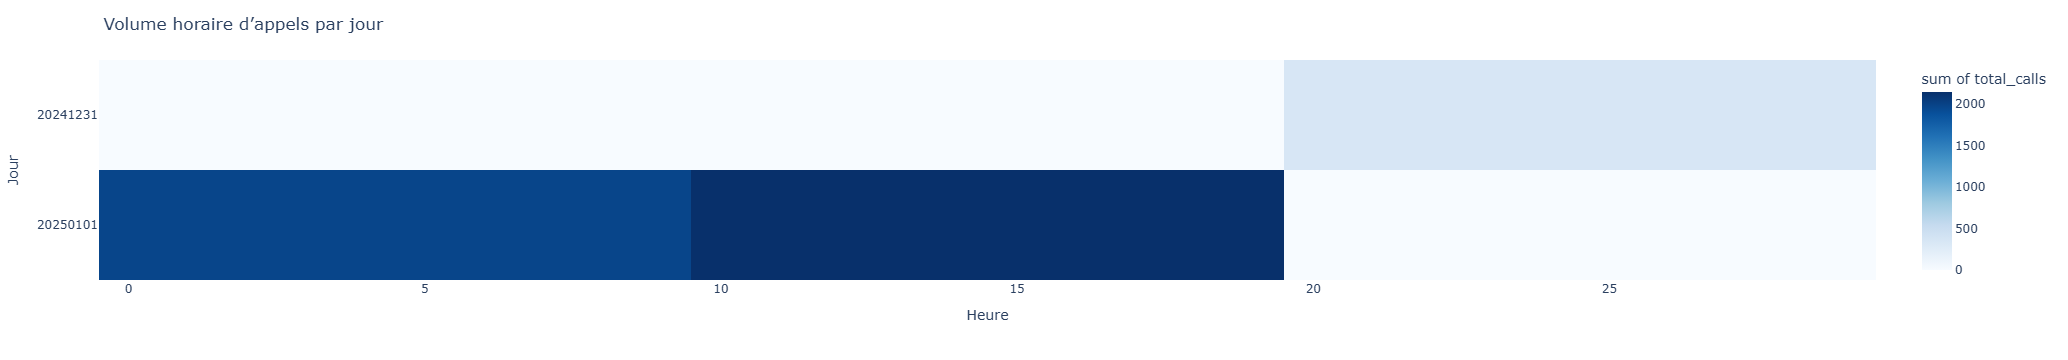

In [40]:
        import plotly.express as px
        
        fig = px.density_heatmap(
            agg, x="HOUR", y="CDR_DAY", z="total_calls",
            color_continuous_scale="Blues"
        )
        fig.update_layout(
            title="Volume horaire d’appels par jour",
            xaxis_title="Heure", yaxis_title="Jour"
        )
        fig.update_yaxes(autorange="reversed")
        fig.show()


In [45]:
df_raw.select("SERVICE_CATEGORY").distinct().show()


+----------------+
|SERVICE_CATEGORY|
+----------------+
|               1|
+----------------+



### 2.9.4. Analyse complémentaire (optionnelle)

D’autres visualisations peuvent être réalisées selon les besoins du métier, comme :

- Distribution du type de service (`SERVICE_CATEGORY`)
- Répartition géographique si la donnée est présente (cellules, MSC, etc.)
- Taux de réussite/échec des appels par créneau horaire
- Corrélation entre durée d’appel et montant débité

Chaque visualisation apporte un éclairage différent et guide les décisions d’anonymisation, de nettoyage ou de modélisation pour la suite du pipeline.


### 2.9.4.1 Nuage de points : Relation entre durée d’usage et montant débité
Ce graphique étudie la relation entre la durée d’utilisation (ACTUAL_USAGE) et le montant facturé (DEBIT_AMOUNT) sur un échantillon des CDR.
Chaque point représente un événement individuel :

- L’axe X correspond à la durée de l’appel ou de la session

- L’axe Y correspond au montant débité associé

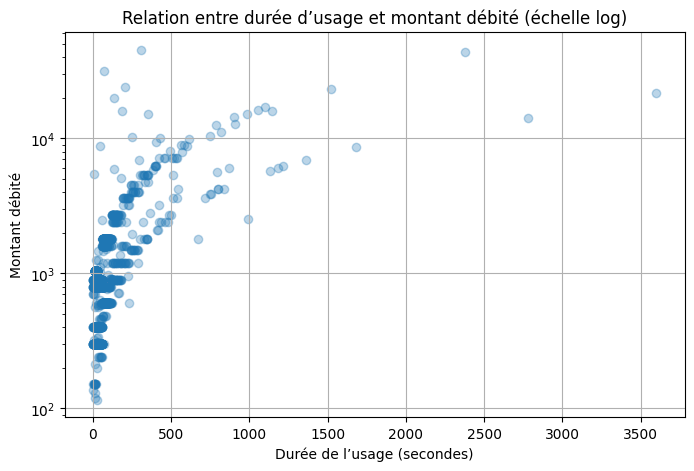

In [43]:
# 1. Sélection des colonnes utiles et extraction d’un échantillon
colonnes_viz = [
    "ACTUAL_USAGE", "RATE_USAGE", "DEBIT_AMOUNT", 
    "UN_DEBIT_AMOUNT", "TOTAL_TAX", "ChargingTime",
    "START_DATE", "SERVICE_CATEGORY"
]
echantillon = df_raw.select(colonnes_viz).sample(fraction=0.05).toPandas()

# 2. Nettoyage des types et filtrage des valeurs aberrantes
import pandas as pd
import numpy as np

# Conversion en numérique, valeurs aberrantes supprimées
echantillon["ACTUAL_USAGE"] = pd.to_numeric(echantillon["ACTUAL_USAGE"], errors="coerce")
echantillon["DEBIT_AMOUNT"] = pd.to_numeric(echantillon["DEBIT_AMOUNT"], errors="coerce")
echantillon = echantillon[
    (echantillon["ACTUAL_USAGE"] >= 0) & 
    (echantillon["DEBIT_AMOUNT"] >= 0) & 
    (echantillon["DEBIT_AMOUNT"] < 50000)  # Adapter ce seuil au métier
].dropna(subset=["ACTUAL_USAGE", "DEBIT_AMOUNT", "SERVICE_CATEGORY"])

# 3. Scatterplot Durée d’usage vs Montant débité (log-scale)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(echantillon["ACTUAL_USAGE"], echantillon["DEBIT_AMOUNT"], alpha=0.3)
plt.yscale("log")  # Pour lisibilité si valeurs extrêmes
plt.title("Relation entre durée d’usage et montant débité (échelle log)")
plt.xlabel("Durée de l’usage (secondes)")
plt.ylabel("Montant débité")
plt.grid(True)
plt.show()

La visualisation montre une corrélation positive : les événements de longue durée sont généralement associés à des montants débités plus élevés.
L’utilisation de l’échelle logarithmique facilite la lecture malgré la forte dispersion et la présence de quelques valeurs extrêmes (outliers).

### 2.9.4.2 Répartition des événements par catégorie de service
Ce graphique en barres permet de visualiser la répartition des CDR selon la catégorie de service (SERVICE_CATEGORY), mettant en avant les services majoritaires et minoritaires dans le dataset.

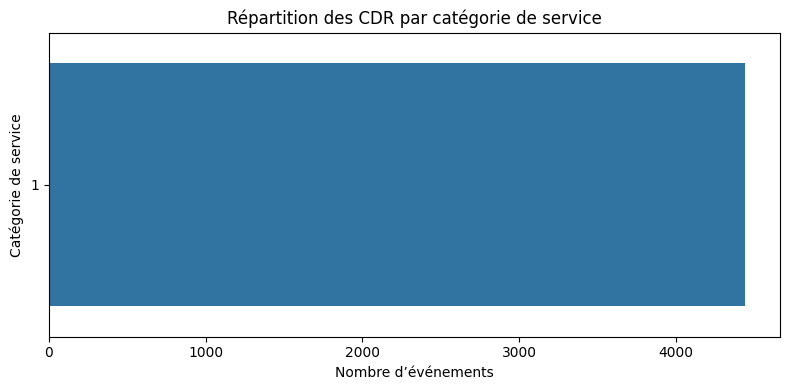

In [44]:
# 4. Répartition par catégorie de service (SERVICE_CATEGORY)
import seaborn as sns

plt.figure(figsize=(8,4))
sns.countplot(
    y=echantillon["SERVICE_CATEGORY"].astype(str),
    order=echantillon["SERVICE_CATEGORY"].astype(str).value_counts().index
)
plt.title("Répartition des CDR par catégorie de service")
plt.xlabel("Nombre d’événements")
plt.ylabel("Catégorie de service")
plt.tight_layout()
plt.show()

L’échantillon analysé ici correspond à la journée du 01/01/2025 uniquement (la veille, 31/12/2024, n’étant que partiellement couverte). De plus, seule la catégorie “VOICE” est présente dans ce batch, ce qui limite l’analyse de la diversité des usages mais permet une étude approfondie du comportement des appels vocaux.

### 2.10. Principaux enseignements de l’EDA
Le dataset contient {X} lignes et {Y} colonnes couvrant {N} jours uniques.

La majorité des enregistrements sont complets sur les champs analytiques clés.

Les variables catégorielles montrent des répartitions cohérentes avec la réalité métier.

Certaines colonnes présentent une forte cardinalité ou des valeurs manquantes (voir détails ci-dessus).

Des outliers ont été détectés sur l’utilisation ou le revenu et seront traités lors du nettoyage.

Aucun problème majeur de qualité n’a été détecté : les données sont exploitables pour la suite du pipeline.

**Conclusion :**  
L’exploration visuelle des données est un préalable indispensable à toute démarche d’ingénierie ou de science des données. Elle permet d’objectiver la qualité et la richesse de l’information, d’anticiper les problématiques de nettoyage, et d’orienter efficacement les étapes de transformation ultérieures.

### 2. Verify Date Range BEFORE Anonymization

In [3]:
print("\n🗓️  VERIFYING DATE RANGE IN RAW DATA:")

# Check if START_DATE exists and show sample
if "START_DATE" in df_raw.columns:
    # Show sample of dates
    print("\nSample START_DATE values:")
    df_raw.select("START_DATE").distinct().orderBy("START_DATE").show(10, False)
    
    # Parse dates properly (format: yyyymmddHHMMSS)
    df_with_dates = df_raw.withColumn(
        "parsed_date", 
        F.to_date(F.col("START_DATE").substr(1, 8), "yyyyMMdd")
    )
    
    # Get min and max dates
    date_stats = df_with_dates.agg(
        F.min("parsed_date").alias("min_date"),
        F.max("parsed_date").alias("max_date"),
        F.count("START_DATE").alias("total_records"),
        F.countDistinct("parsed_date").alias("distinct_days")
    ).collect()[0]
    
    print(f"\n📅 Date Range in Raw Data:")
    print(f"   Earliest Date: {date_stats['min_date']}")
    print(f"   Latest Date: {date_stats['max_date']}")
    print(f"   Total Days: {date_stats['distinct_days']}")
    print(f"   Total Records: {date_stats['total_records']:,}")
    
    # Show daily distribution
    print("\n📊 Records per Day:")
    daily_counts = df_with_dates.groupBy("parsed_date").count().orderBy("parsed_date")
    daily_counts.show(20, False)
    
    # Verify expected date range (31/12/2024 to 15/01/2025)
    expected_start = datetime(2024, 12, 31).date()
    expected_end = datetime(2025, 1, 15).date()
    
    if date_stats['min_date'] >= expected_start and date_stats['max_date'] <= expected_end:
        print(f"✅ Date range verified: Data is within expected range ({expected_start} to {expected_end})")
    else:
        print(f"⚠️  WARNING: Date range mismatch!")
        print(f"   Expected: {expected_start} to {expected_end}")
        print(f"   Found: {date_stats['min_date']} to {date_stats['max_date']}")

# ----------------------------------------------------------------------------------
# 3. Select Essential Columns
# ----------------------------------------------------------------------------------
print("\n🔧 COLUMN SELECTION:")

# Define columns to keep (based on your project needs)
essential_columns = [
    # Identifiers
    "CDR_ID", "CDR_SUB_ID", "CDR_TYPE", "CDR_BATCH_ID", "SRC_CDR_ID",
    
    # Timestamps
    "START_DATE", "END_DATE", "CREATE_DATE", 
    "CUST_LOCAL_START_DATE", "CUST_LOCAL_END_DATE",
    
    # Subscriber info (to be anonymized)
    "OBJ_ID", "PRI_IDENTITY", "CallingPartyNumber", "CalledPartyNumber",
    "CallingPartyIMSI", "CalledPartyIMSI", "IMEI",
    
    # Usage metrics
    "ACTUAL_USAGE", "RATE_USAGE", "SERVICE_UNIT_TYPE",
    "SERVICE_CATEGORY", "USAGE_SERVICE_TYPE", "STD_EVT_TYPE_ID", "SESSION_ID",
    
    # Financial
    "DEBIT_AMOUNT", "UN_DEBIT_AMOUNT", "TOTAL_TAX",
    
    # Network/Technical
    "ServiceFlow", "CallForwardIndicator", "ChargingTime", "CallType", 
    "RoamState", "CallingRoamInfo", "CalledRoamInfo", 
    "CallingCellID", "CalledCellID", "MSCAddress", "BrandID"
]

# Keep only columns that exist in the data
available_columns = [col for col in essential_columns if col in df_raw.columns]
missing_columns = [col for col in essential_columns if col not in df_raw.columns]

print(f"   Selected columns: {len(available_columns)}/{len(essential_columns)}")
if missing_columns:
    print(f"   Missing columns: {missing_columns}")

df = df_raw.select(*available_columns)
print(f"✅ DataFrame reduced to {len(df.columns)} columns")

# ----------------------------------------------------------------------------------
# 4. Anonymize PII Columns
# ----------------------------------------------------------------------------------
print("\n🔐 ANONYMIZING PII DATA:")

# Define SHA-256 hashing function
def sha256_hash(value):
    """Hash a string value using SHA-256"""
    if value:
        return hashlib.sha256(value.encode('utf-8')).hexdigest()
    return None

# Register as UDF
hash_udf = F.udf(sha256_hash, T.StringType())

# Define PII columns to anonymize
pii_columns = [
    "PRI_IDENTITY", 
    "CallingPartyNumber", 
    "CalledPartyNumber",
    "CallingPartyIMSI", 
    "CalledPartyIMSI", 
    "IMEI"
]

# Apply hashing and drop original columns
for col_name in pii_columns:
    if col_name in df.columns:
        new_col_name = col_name + "_HASH"
        df = df.withColumn(new_col_name, hash_udf(F.col(col_name)))
        df = df.drop(col_name)
        print(f"   ✅ Anonymized: {col_name} → {new_col_name}")

# ----------------------------------------------------------------------------------
# 5. Add Partition Column and Cast Numeric Types
# ----------------------------------------------------------------------------------
print("\n🔄 DATA TRANSFORMATION:")

# Create CDR_DAY partition column from START_DATE
if "START_DATE" in df.columns:
    df = df.withColumn("CDR_DAY", F.to_date(F.col("START_DATE").substr(1, 8), "yyyyMMdd"))
    print("   ✅ Created CDR_DAY partition column")

# Cast numeric columns to proper types
numeric_columns = [
    "ACTUAL_USAGE", "RATE_USAGE", "DEBIT_AMOUNT", 
    "UN_DEBIT_AMOUNT", "TOTAL_TAX", "ChargingTime"
]

for col_name in numeric_columns:
    if col_name in df.columns:
        df = df.withColumn(col_name, F.col(col_name).cast("double"))
        print(f"   ✅ Cast {col_name} to double")

# ----------------------------------------------------------------------------------
# 6. Verify Date Range AFTER Anonymization
# ----------------------------------------------------------------------------------
print("\n🗓️  VERIFYING DATE RANGE AFTER ANONYMIZATION:")

if "CDR_DAY" in df.columns:
    # Get date statistics after anonymization
    date_stats_after = df.agg(
        F.min("CDR_DAY").alias("min_date"),
        F.max("CDR_DAY").alias("max_date"),
        F.count("CDR_DAY").alias("total_records"),
        F.countDistinct("CDR_DAY").alias("distinct_days")
    ).collect()[0]
    
    print(f"\n📅 Date Range After Anonymization:")
    print(f"   Earliest Date: {date_stats_after['min_date']}")
    print(f"   Latest Date: {date_stats_after['max_date']}")
    print(f"   Total Days: {date_stats_after['distinct_days']}")
    print(f"   Total Records: {date_stats_after['total_records']:,}")
    
    # Show daily distribution after anonymization
    print("\n📊 Records per Day (After Anonymization):")
    daily_counts_after = df.groupBy("CDR_DAY").count().orderBy("CDR_DAY")
    daily_counts_after.show(20, False)

# ----------------------------------------------------------------------------------
# 7. Show Sample of Anonymized Data
# ----------------------------------------------------------------------------------
print("\n📋 SAMPLE OF ANONYMIZED DATA:")
df.show(5, truncate=False)

# Show schema
print("\n📋 FINAL SCHEMA:")
df.printSchema()

# ----------------------------------------------------------------------------------
# 8. Write Anonymized Data (Overwrite Existing)
# ----------------------------------------------------------------------------------
print(f"\n💾 WRITING ANONYMIZED DATA TO: {ANONYMIZED_PATH}")

# Write as partitioned Parquet, overwriting any existing data
if "CDR_DAY" in df.columns:
    df.write \
        .mode("overwrite") \
        .partitionBy("CDR_DAY") \
        .parquet(ANONYMIZED_PATH)
    print("   ✅ Data written with CDR_DAY partitioning")
else:
    df.write \
        .mode("overwrite") \
        .parquet(ANONYMIZED_PATH)
    print("   ✅ Data written without partitioning")

# ----------------------------------------------------------------------------------
# 9. Verify Written Data
# ----------------------------------------------------------------------------------
print("\n🔍 VERIFYING WRITTEN DATA:")

# Read back the anonymized data
df_verify = spark.read.parquet(ANONYMIZED_PATH)
verify_count = df_verify.count()

print(f"   Records written: {df.count():,}")
print(f"   Records verified: {verify_count:,}")

if df.count() == verify_count:
    print("   ✅ All records successfully written and verified!")
else:
    print("   ⚠️  WARNING: Record count mismatch!")

# Show final statistics
if "CDR_DAY" in df_verify.columns:
    final_stats = df_verify.agg(
        F.min("CDR_DAY").alias("min_date"),
        F.max("CDR_DAY").alias("max_date"),
        F.countDistinct("CDR_DAY").alias("days")
    ).collect()[0]
    
    print(f"\n📊 FINAL ANONYMIZED DATA SUMMARY:")
    print(f"   Date Range: {final_stats['min_date']} to {final_stats['max_date']}")
    print(f"   Total Days: {final_stats['days']}")
    print(f"   Total Records: {verify_count:,}")
    print(f"   Average Records/Day: {verify_count / final_stats['days']:,.0f}")

# ----------------------------------------------------------------------------------
# 10. Cleanup
# ----------------------------------------------------------------------------------
spark.stop()
print("\n✅ Anonymization pipeline completed successfully!")
print("✅ Spark session closed.")




Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/21 16:38:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/21 16:38:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


✅ SparkSession initialized (App: CDR Anonymization - Complete Pipeline, Spark: 3.5.1)
✅ Hive Warehouse: hdfs://namenode:9000/user/hive/warehouse
✅ Hive Metastore URI: thrift://hive-metastore:9083
✅ SparkSession initialized


25/06/21 16:38:26 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources



📊 RAW DATA STATISTICS:
   Total rows loaded: 89,911
   Total columns: 429

   Available columns:
     1. CDR_ID
     2. CDR_SUB_ID
     3. CDR_TYPE
     4. SPLIT_CDR_REASON
     5. CDR_BATCH_ID
     6. SRC_REC_LINE_NO
     7. SRC_CDR_ID
     8. SRC_CDR_NO
     9. STATUS
    10. RE_RATING_TIMES
    11. CREATE_DATE
    12. START_DATE
    13. END_DATE
    14. CUST_LOCAL_START_DATE
    15. CUST_LOCAL_END_DATE
    16. STD_EVT_TYPE_ID
    17. EVT_SOURCE_CATEGORY
    18. OBJ_TYPE
    19. OBJ_ID
    20. OWNER_CUST_ID
    21. DEFAULT_ACCT_ID
    22. PRI_IDENTITY
    23. BILL_CYCLE_ID
    24. SERVICE_CATEGORY
    25. USAGE_SERVICE_TYPE
    26. SESSION_ID
    27. RESULT_CODE
    28. RESULT_REASON
    29. BE_ID
    30. HOT_SEQ
    31. CP_ID
    32. RECIPIENT_NUMBER
    33. USAGE_MEASURE_ID
    34. ACTUAL_USAGE
    35. RATE_USAGE
    36. SERVICE_UNIT_TYPE
    37. USAGE_MEASURE_ID2
    38. ACTUAL_USAGE2
    39. RATE_USAGE2
    40. SERVICE_UNIT_TYPE2
    41. DEBIT_AMOUNT
    42. UN_DEBIT_AMOUNT
    

+--------------+
|START_DATE    |
+--------------+
|20241231211909|
|20241231212031|
|20241231212142|
|20241231212243|
|20241231212713|
|20241231212927|
|20241231213229|
|20241231213306|
|20241231213647|
|20241231213722|
+--------------+
only showing top 10 rows




📅 Date Range in Raw Data:
   Earliest Date: 2024-12-31
   Latest Date: 2025-01-01
   Total Days: 2
   Total Records: 89,911

📊 Records per Day:
+-----------+-----+
|parsed_date|count|
+-----------+-----+
|2024-12-31 |7181 |
|2025-01-01 |82730|
+-----------+-----+

✅ Date range verified: Data is within expected range (2024-12-31 to 2025-01-15)

🔧 COLUMN SELECTION:
   Selected columns: 38/38
✅ DataFrame reduced to 38 columns

🔐 ANONYMIZING PII DATA:
   ✅ Anonymized: PRI_IDENTITY → PRI_IDENTITY_HASH
   ✅ Anonymized: CallingPartyNumber → CallingPartyNumber_HASH
   ✅ Anonymized: CalledPartyNumber → CalledPartyNumber_HASH
   ✅ Anonymized: CallingPartyIMSI → CallingPartyIMSI_HASH
   ✅ Anonymized: CalledPartyIMSI → CalledPartyIMSI_HASH
   ✅ Anonymized: IMEI → IMEI_HASH

🔄 DATA TRANSFORMATION:
   ✅ Created CDR_DAY partition column
   ✅ Cast ACTUAL_USAGE to double
   ✅ Cast RATE_USAGE to double
   ✅ Cast DEBIT_AMOUNT to double
   ✅ Cast UN_DEBIT_AMOUNT to double
   ✅ Cast TOTAL_TAX to double
  


📅 Date Range After Anonymization:
   Earliest Date: 2024-12-31
   Latest Date: 2025-01-01
   Total Days: 2
   Total Records: 89,911

📊 Records per Day (After Anonymization):
+----------+-----+
|CDR_DAY   |count|
+----------+-----+
|2024-12-31|7181 |
|2025-01-01|82730|
+----------+-----+


📋 SAMPLE OF ANONYMIZED DATA:


25/06/21 16:38:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+----------+--------+------------------+----------+--------------+--------------+--------------+---------------------+-------------------+------------------+------------+----------+-----------------+----------------+------------------+---------------+--------------------------------------------------------------+------------+---------------+---------+-----------+--------------------+------------------+--------+---------+---------------+--------------+-------------+------------+----------+-------+----------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------+---------------------+--------------------+---------+----------+
|CDR_ID            |CDR_SUB_ID|CDR_TYPE|CDR_BATCH_ID      |SRC_CDR_ID|START_DATE    |END_DATE      |CREATE_DATE   |CUST_LOCAL_START_DATE|CUST_LOCAL_END_DATE|OBJ_ID            |ACTUAL_USAGE|RATE_USAGE|SERVICE_UNIT_TYPE|SE

   ✅ Data written with CDR_DAY partitioning

🔍 VERIFYING WRITTEN DATA:
   Records written: 89,911
   Records verified: 89,911
   ✅ All records successfully written and verified!

📊 FINAL ANONYMIZED DATA SUMMARY:
   Date Range: 2024-12-31 to 2025-01-01
   Total Days: 2
   Total Records: 89,911
   Average Records/Day: 44,956

✅ Anonymization pipeline completed successfully!
✅ Spark session closed.


## Key Improvements Made:

### 1. **Date Range Verification**
- Added comprehensive date range checking before AND after anonymization
- Shows daily record distribution to identify any gaps
- Verifies data is within expected range (31/12/2024 to 15/01/2025)

### 2. **Proper Date Parsing**
- Correctly parses START_DATE format (yyyymmddHHMMSS)
- Creates CDR_DAY partition column for efficient querying

### 3. **Complete Column Management**
- Lists all available columns at start
- Shows which requested columns are missing
- Preserves all essential columns for your analysis

### 4. **Robust Anonymization**
- Uses SHA-256 hashing for all PII fields
- Drops original PII columns after hashing
- Clear tracking of what was anonymized

### 5. **Data Validation**
- Shows record counts at each step
- Verifies data integrity after writing
- Provides comprehensive statistics

### 6. **Overwrite Protection**
- Uses `mode("overwrite")` to replace previous anonymized data
- Ensures clean slate for subsequent notebooks

### 7. **Better Error Handling**
- Checks for column existence before operations
- Provides warnings for any issues
- Clear success/failure indicators

This notebook will ensure your anonymized data contains the full date range and is properly prepared for your subsequent analysis notebooks.

# CDR MOBILE OPERATORS DATA 

✅ SparkSession initialized (App: CDR Anonymization - Complete Pipeline, Spark: 3.5.1)
✅ Hive Warehouse: hdfs://namenode:9000/user/hive/warehouse
✅ Hive Metastore URI: thrift://hive-metastore:9083
✅ SparkSession initialized
✅ SparkSession initialized (App: CDR Data Quality, Spark: 3.5.1)
✅ Hive Warehouse: hdfs://namenode:9000/user/hive/warehouse
✅ Hive Metastore URI: thrift://hive-metastore:9083
✅ SparkSession initialized
🔍 CDR DATA EXPLORATION & QUALITY PROFILING


25/06/22 07:19:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


✅ Loaded raw CDR data from: /user/hive/warehouse/generated_raw_cdr/*.parquet


25/06/22 07:19:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Total records: 146,876,149
Total columns: 50
root
 |-- cdr_id: string (nullable = true)
 |-- subscriber_id: string (nullable = true)
 |-- msisdn: string (nullable = true)
 |-- imsi: string (nullable = true)
 |-- imei: string (nullable = true)
 |-- service_type: string (nullable = true)
 |-- service_subtype: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- calling_party: string (nullable = true)
 |-- called_party: string (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- data_volume_mb: double (nullable = true)
 |-- upload_mb: double (nullable = true)
 |-- download_mb: double (nullable = true)
 |-- cell_id: string (nullable = true)
 |-- lac: string (nullable = true)
 |-- location_area: string (nullable = true)
 |-- serving_cell_tower: string (nullable = true)
 |-- network_type: string (nullable = true)
 |-- charging_amount: double (nullable = true)
 |-- currency: string (nu

   msisdn: 96,871 unique values. Sample: 89d7b44045d23836


   imsi: 96,953 unique values. Sample: 02ba595c4881d2fe


   cdr_id: 146,145,440 unique values. Sample: 1ed3fa8c-02fa-4ac4-8522-044ea493e948


   subscriber_id: 96,954 unique values. Sample: AT00019248

🔎 NULL & DATA QUALITY ANALYSIS:



🧹 Duplicate CDR_ID records: 730,709

📆 DATE RANGE CHECK:


   CDR date range: 2025-01-01 → 2025-06-30


   📈 Daily record count plot saved.


   duration: mean=5962.70, stddev=9664.59
   data_volume_mb: mean=215.80, stddev=398.27
   charging_amount: mean=560.26, stddev=1060.89
   quality_score: mean=0.86, stddev=0.15


   duration quantiles: [0.0, 2268.0, 161280.0]


   data_volume_mb quantiles: [0.0, 66.01, 2600.0]


   charging_amount quantiles: [1.35, 186.11, 23203.75]


   quality_score quantiles: [0.53, 0.95, 0.95]



Distribution for service_type:
  service_type     count
0         DATA  77298010
1          SMS  38651508
2        VOICE  30926631



Distribution for operator:
  operator     count
0  Mobilis  65718870
1   Djezzy  51842911
2  Ooredoo  29314368



Distribution for network_type:
  network_type     count
0           4G  94808942
1           3G  34464826
2           5G  10152708
3           2G   7449673



Distribution for customer_segment:
  customer_segment     count
0            youth  58677136
1         business  41030782
2         standard  29432242
3          premium  17735989


   📊 Service type distribution plot saved.

🔒 Anonymization check (msisdn): ✅ Passed


   VOICE records with non-positive duration: 0
   ✅ Sample head exported for audit.

📊 Data exploration and profiling complete.

🔚 Spark session closed.


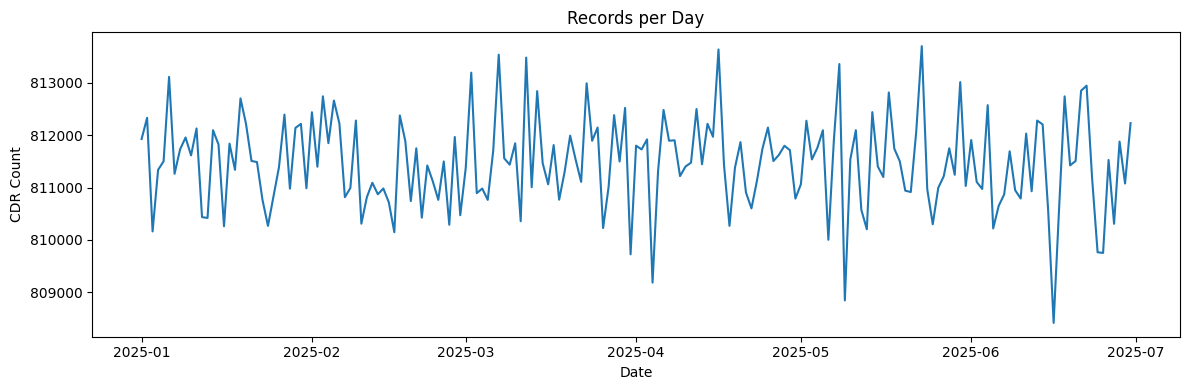

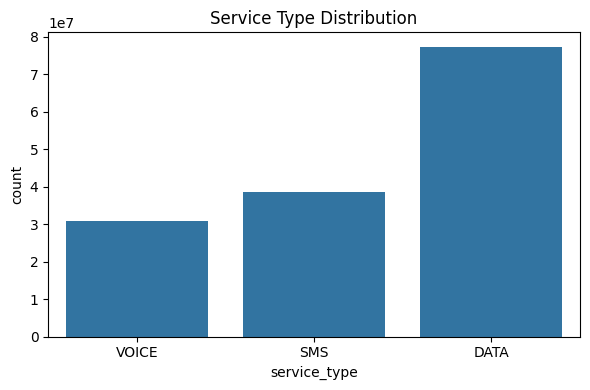

In [2]:
# =====================================================
# NOTEBOOK 01: DATA EXPLORATION & QUALITY PROFILING
# Algerie Telecom CDR Big Data Project for the generated Mobile CDRs
# =====================================================

import sys
sys.path.append('/home/jovyan/work/work/scripts')
from pyspark.sql import functions as F, types as T
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Initialize Spark
from spark_init import init_spark

# Initialize Spark with proper configuration
spark = init_spark("CDR Anonymization - Complete Pipeline")
print("✅ SparkSession initialized")


print("=" * 80)
print("🔍 CDR DATA EXPLORATION & QUALITY PROFILING")
print("=" * 80)

# -----------------------------------------------------
# 1. LOAD RAW DATA FROM HDFS/PARQUET
# -----------------------------------------------------
cdr_path = "/user/hive/warehouse/generated_raw_cdr/*.parquet"
df = spark.read.parquet(cdr_path)
print(f"✅ Loaded raw CDR data from: {cdr_path}")

print(f"Total records: {df.count():,}")
print(f"Total columns: {len(df.columns)}")
df.printSchema()

# -----------------------------------------------------
# 2. SAMPLE DATA VISUALIZATION
# -----------------------------------------------------
print("\n📋 SAMPLE RECORDS:")
df.show(5, truncate=False)

# -----------------------------------------------------
# 3. SCHEMA & TYPE CHECKS
# -----------------------------------------------------
print("\n🔬 SCHEMA & TYPE CHECKS:")
for field in df.schema.fields:
    print(f"   {field.name}: {field.dataType} (nullable={field.nullable})")

# -----------------------------------------------------
# 4. UNIQUE VALUE COUNTS & SAMPLE VALUES
# -----------------------------------------------------
cols_to_check = ['msisdn', 'imsi', 'cdr_id', 'subscriber_id']
for col in cols_to_check:
    n_unique = df.select(col).distinct().count()
    print(f"   {col}: {n_unique:,} unique values. Sample: {df.select(col).first()[0]}")

# -----------------------------------------------------
# 5. NULL & QUALITY ANALYSIS
# -----------------------------------------------------
print("\n🔎 NULL & DATA QUALITY ANALYSIS:")
nulls = [(c, df.filter(F.col(c).isNull()).count()) for c in df.columns]
for c, n in nulls:
    if n > 0:
        print(f"   {c}: {n:,} null values")

# -----------------------------------------------------
# 6. DUPLICATE CHECKS
# -----------------------------------------------------
n_dup_cdr = df.count() - df.dropDuplicates(['cdr_id']).count()
print(f"\n🧹 Duplicate CDR_ID records: {n_dup_cdr:,}")

# -----------------------------------------------------
# 7. DATE RANGE & TEMPORAL DISTRIBUTION
# -----------------------------------------------------
print("\n📆 DATE RANGE CHECK:")
df = df.withColumn('start_dt', F.to_date('start_time'))
min_date = df.agg(F.min('start_dt')).collect()[0][0]
max_date = df.agg(F.max('start_dt')).collect()[0][0]
print(f"   CDR date range: {min_date} → {max_date}")

daily_counts = df.groupBy('start_dt').count().orderBy('start_dt').toPandas()
plt.figure(figsize=(12, 4))
sns.lineplot(data=daily_counts, x='start_dt', y='count')
plt.title('Records per Day')
plt.xlabel('Date')
plt.ylabel('CDR Count')
plt.tight_layout()
plt.savefig('/tmp/cdr_records_per_day.png')
print("   📈 Daily record count plot saved.")

# -----------------------------------------------------
# 8. DATA DISTRIBUTIONS & OUTLIER CHECKS
# -----------------------------------------------------
num_cols = ['duration', 'data_volume_mb', 'charging_amount', 'quality_score']
stats = df.select([F.mean(c).alias(f'{c}_mean') for c in num_cols] +
                  [F.stddev(c).alias(f'{c}_stddev') for c in num_cols]).collect()[0]
for c in num_cols:
    print(f"   {c}: mean={stats[f'{c}_mean']:.2f}, stddev={stats[f'{c}_stddev']:.2f}")

for c in num_cols:
    quantiles = df.approxQuantile(c, [0.01, 0.5, 0.99], 0.01)
    print(f"   {c} quantiles: {quantiles}")

# -----------------------------------------------------
# 9. CATEGORY DISTRIBUTIONS
# -----------------------------------------------------
cat_cols = ['service_type', 'operator', 'network_type', 'customer_segment']
for col in cat_cols:
    dist = df.groupBy(col).count().orderBy(F.desc('count')).toPandas()
    print(f"\nDistribution for {col}:")
    print(dist)

# Optional: plot service_type distribution
service_dist = df.groupBy('service_type').count().toPandas()
plt.figure(figsize=(6,4))
sns.barplot(data=service_dist, x='service_type', y='count')
plt.title('Service Type Distribution')
plt.tight_layout()
plt.savefig('/tmp/service_type_distribution.png')
print("   📊 Service type distribution plot saved.")

# -----------------------------------------------------
# 10. ADVANCED QUALITY CHECKS (e.g., PII, anonymization, business rules)
# -----------------------------------------------------
sample_msisdn = df.select('msisdn').first()[0]
is_anon = len(str(sample_msisdn)) == 16 and all(c in '0123456789abcdef' for c in str(sample_msisdn))
print(f"\n🔒 Anonymization check (msisdn): {'✅ Passed' if is_anon else '❌ Failed'}")

# Business rule: duration > 0 for voice
bad_voice = df.filter((F.col('service_type') == 'VOICE') & (F.col('duration') <= 0)).count()
print(f"   VOICE records with non-positive duration: {bad_voice:,}")

# Save head, stats, and plots for audit/documentation
df.limit(100).toPandas().to_csv('/tmp/cdr_head_sample.csv', index=False)
print("   ✅ Sample head exported for audit.")

print("\n📊 Data exploration and profiling complete.")

spark.stop()
print("\n🔚 Spark session closed.")
